## Instalação de dependências necessárias

In [1]:
!uv add pandas
!uv add numpy
!uv add seaborn
!uv add matplotlib
!uv add scikit-learn

Resolved 50 packages in 1ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.39ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.42ms
Audited 19 packages in 0.04ms
Resolved 50 packages in 0.42ms
Audited 19 packages in 0.03ms
Resolved 50 packages in 0.35ms
Audited 19 packages in 0.03ms


## Importação de dependências

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



## Carregamento dos dados

In [3]:
wine_data_csv_file_path = os.path.join('data', 'winequalityN.csv')
wine_data = pd.read_csv(wine_data_csv_file_path)

# Analisando valores nulos

In [4]:
wine_data.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [5]:
wine_data.dropna(inplace=True)

wine_data.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Criação da variável "opinion"
O exercício solicite que uma variável categórica "opinion" seja criada com base na variável "quality".

- O valor de opinion é 0, quando quality for menor ou igual a 5.
- O valor de opinion é 1, quando quality for maior que 5.

In [6]:
wine_data["opinion"] = np.where(wine_data["quality"] <= 5, 0, 1)

In [7]:
# Analisar o balanceamento das classes
wine_data.opinion.value_counts(normalize=True)

opinion
1    0.632988
0    0.367012
Name: proportion, dtype: float64

### Contagem do total de vinhos de cada tipo
Conforme definido no exercício, devemos utilizar inicialmente somente a base de vinhos do tipo "branco". O dataset fornecido no Kaggle contém vinhos do tipo "branco" e "tinto". Para isso irei inicialmente realizar a contagem do total de vinhos de cada tipo e posteriormente separar as bases de vinhos brancos e tintos. Por último vou fazer a contagem de cada tipo de vinho para se certificar de que não houve alguma remoção acidental.

In [8]:
# Contagem do total de vinhos de cada tipo
print("\n📊 Contagem total de vinhos:")
print(wine_data["type"].value_counts())
print("-"*50)


📊 Contagem total de vinhos:
type
white    4870
red      1593
Name: count, dtype: int64
--------------------------------------------------


In [9]:
# Separação dos vinhos brancos e tintos
white_wine_data = wine_data[wine_data["type"] == "white"]
red_wine_data = wine_data[wine_data["type"] == "red"]

In [10]:
# Certificando que a quantidade de vinhos brancos é a mesma
print("🍾 Vinhos Brancos:")
print(white_wine_data["type"].value_counts())
print("-"*50)

# Certificando que a quantidade de vinhos tintos é a mesma
print("🍷 Vinhos Tintos:")
print(red_wine_data["type"].value_counts())
print("-"*50)

🍾 Vinhos Brancos:
type
white    4870
Name: count, dtype: int64
--------------------------------------------------
🍷 Vinhos Tintos:
type
red    1593
Name: count, dtype: int64
--------------------------------------------------


### Entendendo as variáveis
Antes de começar a análise de dados, é importante entender as variáveis envolvidas.

#### Exibir os tipos de cada variável

Com base na análise realizada abaixo, as variáveis se dividem em:
- Categóricas: type, opinion
- Contínua: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
- Discreta: quality

In [11]:
white_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4870 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4870 non-null   object 
 1   fixed acidity         4870 non-null   float64
 2   volatile acidity      4870 non-null   float64
 3   citric acid           4870 non-null   float64
 4   residual sugar        4870 non-null   float64
 5   chlorides             4870 non-null   float64
 6   free sulfur dioxide   4870 non-null   float64
 7   total sulfur dioxide  4870 non-null   float64
 8   density               4870 non-null   float64
 9   pH                    4870 non-null   float64
 10  sulphates             4870 non-null   float64
 11  alcohol               4870 non-null   float64
 12  quality               4870 non-null   int64  
 13  opinion               4870 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 570.7+ KB


#### Obtenção das médias e desvios padrões para cada variável

- Nota: Estou removendo a variável "opinion" por conta dela ser do tipo "categórica" e portanto seria sem sentido fazer média e desvio padrão dela.

In [12]:
white_wine_data.drop(columns=["opinion"]).describe().loc[["mean", "std"]]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,6.855123,0.278071,0.334199,6.394343,0.045771,35.317146,138.340144,0.994026,3.188154,0.489700,10.516772,5.878029
std,0.843444,0.100528,0.120915,5.070853,0.021846,17.012967,42.490515,0.002993,0.150902,0.114196,1.231251,0.885699


# Etapas necessárias para criar um modelo de classificação
1. Preparação dos dados

# Preparação dos dados

- Remover a variável "quality" que deve ser desconsiderada para a criação do modelo.
- Remover a variável "type" tendo em vista que nesse momento só será utilizado a base de vinhos brancos.

In [13]:
white_wine_data.drop(columns=["quality", "type"], inplace=True)

/var/folders/_z/2mdksj291s782py9yt8kqq1r0000gn/T/ipykernel_20210/2410564594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_wine_data.drop(columns=["quality", "type"], inplace=True)


In [14]:
# Avaliar valores nulos
white_wine_data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
opinion                 0
dtype: int64

In [15]:
white_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4870 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4870 non-null   float64
 1   volatile acidity      4870 non-null   float64
 2   citric acid           4870 non-null   float64
 3   residual sugar        4870 non-null   float64
 4   chlorides             4870 non-null   float64
 5   free sulfur dioxide   4870 non-null   float64
 6   total sulfur dioxide  4870 non-null   float64
 7   density               4870 non-null   float64
 8   pH                    4870 non-null   float64
 9   sulphates             4870 non-null   float64
 10  alcohol               4870 non-null   float64
 11  opinion               4870 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 494.6 KB


# Separabilidade linear

Verificar se existem variáveis que permitem separar linearmente o dataset.

In [16]:
# Avaliação da distribuição de classes
white_wine_data['opinion'].value_counts()

opinion
1    3240
0    1630
Name: count, dtype: int64

O comando abaixo plota as combinações de pares que podem ser utilizados para identificar se o dataset pode ser separado linearmente.

- Nota: Devido a grande quantidade de variáveis, o tempo de execução pode ser elevado. Dessa forma, estou deixando o comando comentado e disponibilizo a imagem do resultado abaixo:

![avaliação de separabilidade linear do dataset de vinhos brancos](assets/separabilidade-linear-pairplot.png)

In [17]:
# sns.pairplot(data=white_wine_data, hue='opinion')

#### Análise da viabilidade de separação linear

Com base na observação visual dos pares de variáveis plotados acima, não é possível ter certeza se o dataset de vinhos brancos pode ser separado linearmente. Será necessário continuar a análise porque observando somente com as duas dimensões do gráfico essa separação não pode ser confirmada.

## Matriz de confusão

A ideia é avaliar as previsões do modelo. A variável "opinion" é a variável que estamos tentando prever. Nesse caso, vou criar dois modelos fictícios: otimista e pessimista. Após a avaliação das métricas, podemos definir a métrica que servirá como baseline para nosso modelo, ou seja, a métrica que o modelo precisará obter um resultado melhor para poder ser considerado viável.

- Modelo otimista: todos os vinhos são bons
- Modelo pessimista: todos os vinhos são ruins

#### Criação dos modelos otimistas e pessimistas

In [18]:
pessimistic_y = [0] * len(white_wine_data.opinion)
optimistic_y = [1] * len(white_wine_data.opinion)

#### Plotagem da matriz de confusão otimista

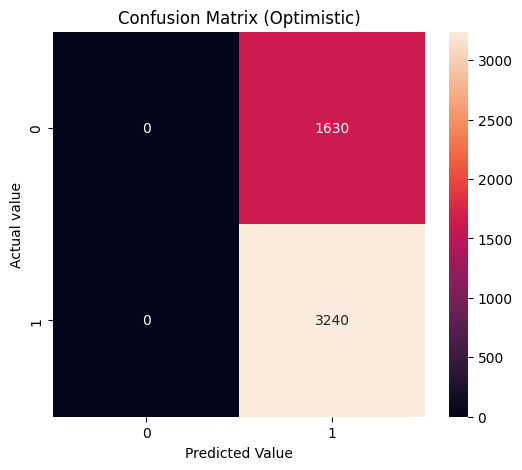

In [19]:
optimistic_confusion_matrix = confusion_matrix(white_wine_data.opinion, optimistic_y)

plt.figure(figsize=(6, 5))
sns.heatmap(optimistic_confusion_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")
plt.title("Confusion Matrix (Optimistic)")
plt.show()

#### Calculando as métricas para o modelo otimista

Analisando as métricas é possível notar que para o modelo otimista, temos:
- Acurácia: ~0.67
- Precisão: ~0.67
- Recall: 1.00
- F1-score: ~0.80

In [20]:
print('Acurácia (Otimista): ', accuracy_score(white_wine_data.opinion, optimistic_y))
print('Precisão (Otimista): ', precision_score(white_wine_data.opinion, optimistic_y))
print('Recall (Otimista): ', recall_score(white_wine_data.opinion, optimistic_y))
print('F1 Score (Otimista): ', f1_score(white_wine_data.opinion, optimistic_y))

Acurácia (Otimista):  0.6652977412731006
Precisão (Otimista):  0.6652977412731006
Recall (Otimista):  1.0
F1 Score (Otimista):  0.7990135635018496


#### Plotagem da matriz de confusão pessimista

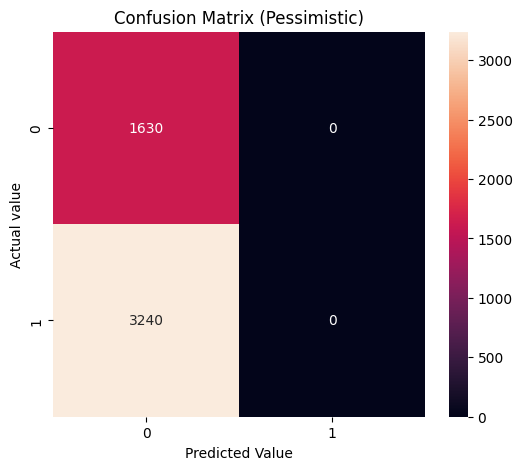

In [21]:
pessimistic_confusion_matrix = confusion_matrix(white_wine_data.opinion, pessimistic_y)

plt.figure(figsize=(6, 5))
sns.heatmap(pessimistic_confusion_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Actual value")
plt.title("Confusion Matrix (Pessimistic)")
plt.show()

#### Calculando as métricas do modelo pessimista

Analisando as métricas é possível notar que para o modelo pessimista, temos:
- Acurácia: ~0.33
- Precisão: 0.0
- Recall: 0.0
- F1-score: 0.0

In [22]:
print('Acurácia (Pessimista): ', accuracy_score(white_wine_data.opinion, pessimistic_y))
print('Precisão (Pessimista): ', precision_score(white_wine_data.opinion, pessimistic_y))
print('Recall (Pessimista): ', recall_score(white_wine_data.opinion, pessimistic_y))
print('F1 Score (Pessimista): ', f1_score(white_wine_data.opinion, pessimistic_y))

Acurácia (Pessimista):  0.3347022587268994
Precisão (Pessimista):  0.0
Recall (Pessimista):  0.0
F1 Score (Pessimista):  0.0


/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
white_wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,opinion
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4891,5.7,0.21,0.32,0.9,0.038,38.0,121.0,0.99074,3.24,0.46,10.6,1
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1


# Separação entre treino e teste

In [24]:
# separando x e y
X = white_wine_data.drop(columns=['opinion'])
y = white_wine_data[['opinion']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [25]:
# análise de proporções
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.665298,0.665298,0.665298
1,0.334702,0.334702,0.334702


#### Criação de um modelo baseline

Abaixo irei criar um modelo baseline com o objetivo de ter uma base para comparar o desempenho.

In [26]:
y_base = np.repeat(1, repeats=len(y_test))
y_base

array([1, 1, 1, ..., 1, 1, 1], shape=(1461,))

In [27]:
# Calcular métricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       489
           1       0.67      1.00      0.80       972

    accuracy                           0.67      1461
   macro avg       0.33      0.50      0.40      1461
weighted avg       0.44      0.67      0.53      1461



/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precis

In [28]:
# Avaliar as grandezas do X
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
136,8.2,0.23,0.40,1.20,0.027,36.0,121.0,0.9920,3.12,0.38,10.7
1519,8.3,0.20,0.49,1.70,0.040,34.0,169.0,0.9938,3.05,0.37,10.1
1642,7.3,0.19,0.49,15.55,0.058,50.0,134.0,0.9998,3.42,0.36,9.1
1369,7.4,0.64,0.47,14.15,0.168,42.0,185.0,0.9984,2.90,0.49,9.3
193,6.6,0.15,0.34,5.10,0.055,34.0,125.0,0.9942,3.36,0.42,9.6


In [ ]:
# Criando um pipeline de modelagem
log_reg_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty=None))
])

log_reg_pipeline.fit(X_train, y_train)

/Users/alexandrelara/Documents/storage/c/code/project-algoritmos-de-ia-para-classificacao/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', RobustScaler()),
                ('model', LogisticRegression(penalty=None))])